<a href="https://colab.research.google.com/github/Abdul-ur-Rehman-Butt/2022-SE-27_LAB_TASKS_ML/blob/main/Dollar_Bill_Detection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dollar Bill Detection using CNN
## Quiz 2 - Complete Implementation

This notebook implements a CNN-based dollar bill classifier that:
1. Loads and explores the dataset
2. Splits data into train and test sets
3. Trains a CNN model
4. Evaluates model performance

**Dataset Classes:** $1, $5, $10, $20 bills

## Step 1: Setup and Install Dependencies

In [1]:
# Install required packages
!pip install -q pillow matplotlib numpy tensorflow scikit-learn

In [2]:
# Import libraries
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2: Upload Dataset to Colab

**Instructions:**
1. Click on the folder icon in the left sidebar
2. Click the upload button
3. Upload your `dataset_zip.zip` file
4. Wait for upload to complete
5. Run the cell below to extract

In [5]:
# Extract the uploaded zip file
!unzip -q dataset.zip.zip
!ls -la Bill_dataset/

total 36
drwxr-xr-x 6 root root  4096 Jan 31 09:10 .
drwxr-xr-x 1 root root  4096 Feb  1 19:14 ..
drwxr-xr-x 2 root root  4096 Jan  4  2025 1
drwxr-xr-x 2 root root  4096 Jan  4  2025 10
drwxr-xr-x 2 root root  4096 Jan  4  2025 20
drwxr-xr-x 2 root root  4096 Jan  4  2025 5
-rw-r--r-- 1 root root 10244 Jan 31 09:10 .DS_Store


## Step 3: Explore the Dataset

In [6]:
# Dataset paths
dataset_path = 'Bill_dataset'
classes = ['1', '5', '10', '20']

# Count images in each class
print("Dataset Structure:")
print("="*50)
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith('.tif')])
        print(f"${class_name} bills: {num_images} images")
    else:
        print(f"${class_name} bills: Directory not found!")

Dataset Structure:
$1 bills: 90 images
$5 bills: 13 images
$10 bills: 22 images
$20 bills: 36 images


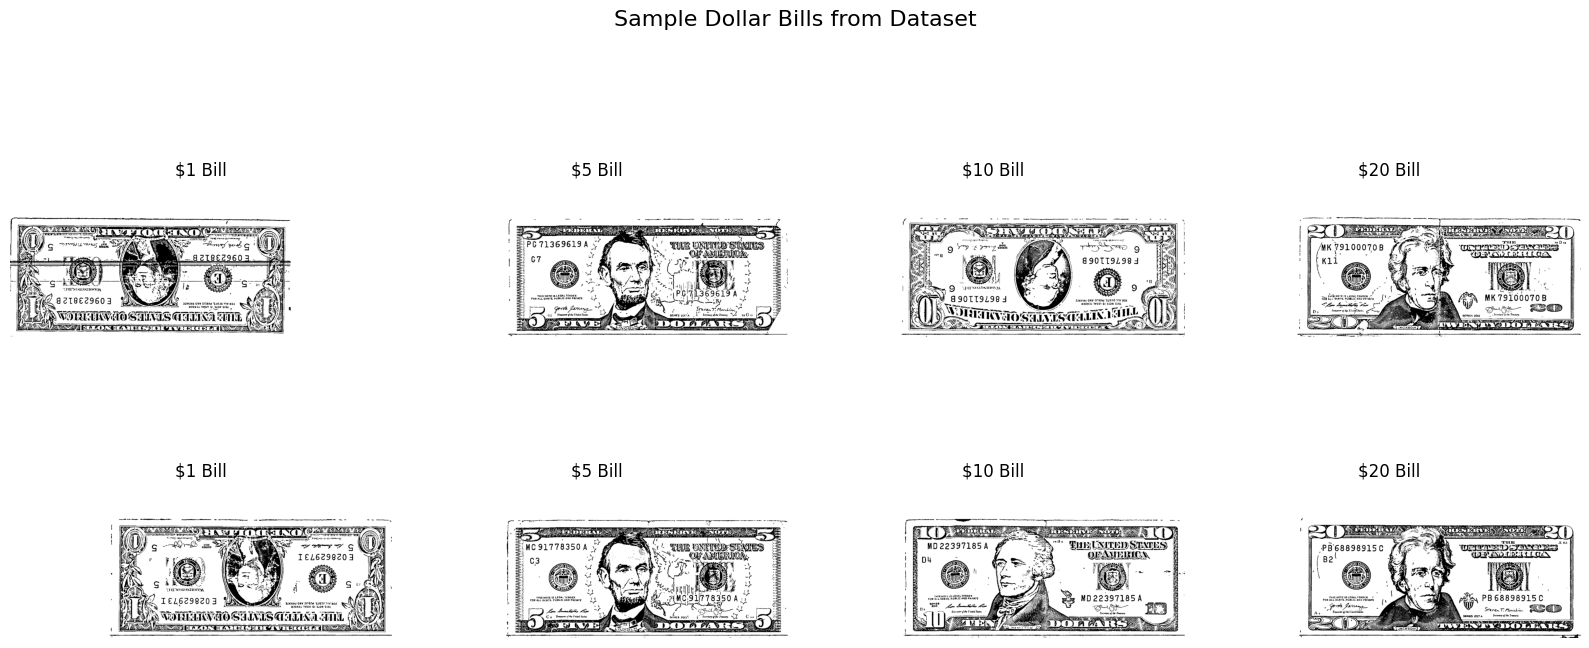


Sample Image Properties:
Size: (1677, 677)
Mode: 1


In [7]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Dollar Bills from Dataset', fontsize=16)

for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith('.tif')]

    # Display 2 random images per class
    for i in range(2):
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        ax = axes[i, idx]
        ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
        ax.set_title(f'${class_name} Bill')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Check image properties
sample_img = Image.open(os.path.join(dataset_path, '1', os.listdir(os.path.join(dataset_path, '1'))[0]))
print(f"\nSample Image Properties:")
print(f"Size: {sample_img.size}")
print(f"Mode: {sample_img.mode}")

## Step 4: Create Train/Test Split

**Important:** This step moves images from the original dataset to create a test set.
Test images will NOT be in the training set.

In [8]:
# Configuration
TEST_SPLIT = 0.2  # 20% for testing
train_dir = 'train_data'
test_dir = 'test_data'

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

print("Created train and test directories")

Created train and test directories


In [9]:
# Split data into train and test sets
print("Splitting dataset into train and test sets...")
print("="*60)

for class_name in classes:
    # Get all images for this class
    class_path = os.path.join(dataset_path, class_name)
    all_images = [f for f in os.listdir(class_path) if f.endswith('.tif')]

    # Shuffle images
    random.shuffle(all_images)

    # Calculate split point
    num_test = max(1, int(len(all_images) * TEST_SPLIT))  # At least 1 image for test
    num_train = len(all_images) - num_test

    # Split images
    test_images = all_images[:num_test]
    train_images = all_images[num_test:]

    # Copy test images
    for img_name in test_images:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(test_dir, class_name, img_name)
        shutil.copy2(src, dst)

    # Copy train images
    for img_name in train_images:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(train_dir, class_name, img_name)
        shutil.copy2(src, dst)

    print(f"${class_name:2s} bills: {num_train:2d} train, {num_test:2d} test")

print("="*60)
print("Data split completed successfully!")

Splitting dataset into train and test sets...
$1  bills: 72 train, 18 test
$5  bills: 11 train,  2 test
$10 bills: 18 train,  4 test
$20 bills: 29 train,  7 test
Data split completed successfully!


In [10]:
# Verify no overlap between train and test
print("\nVerifying no overlap between train and test sets...")
overlap_found = False

for class_name in classes:
    train_files = set(os.listdir(os.path.join(train_dir, class_name)))
    test_files = set(os.listdir(os.path.join(test_dir, class_name)))

    overlap = train_files.intersection(test_files)
    if overlap:
        print(f"⚠️  WARNING: ${class_name} has {len(overlap)} overlapping files!")
        overlap_found = True

if not overlap_found:
    print("✓ No overlap detected - Train and test sets are properly separated!")


Verifying no overlap between train and test sets...
✓ No overlap detected - Train and test sets are properly separated!


## Step 5: Data Preprocessing and Augmentation

In [11]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
NUM_CLASSES = 4

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nClass indices: {train_generator.class_indices}")
print(f"Total training samples: {train_generator.samples}")
print(f"Total test samples: {test_generator.samples}")

Found 130 images belonging to 4 classes.
Found 31 images belonging to 4 classes.

Class indices: {'1': 0, '10': 1, '20': 2, '5': 3}
Total training samples: 130
Total test samples: 31


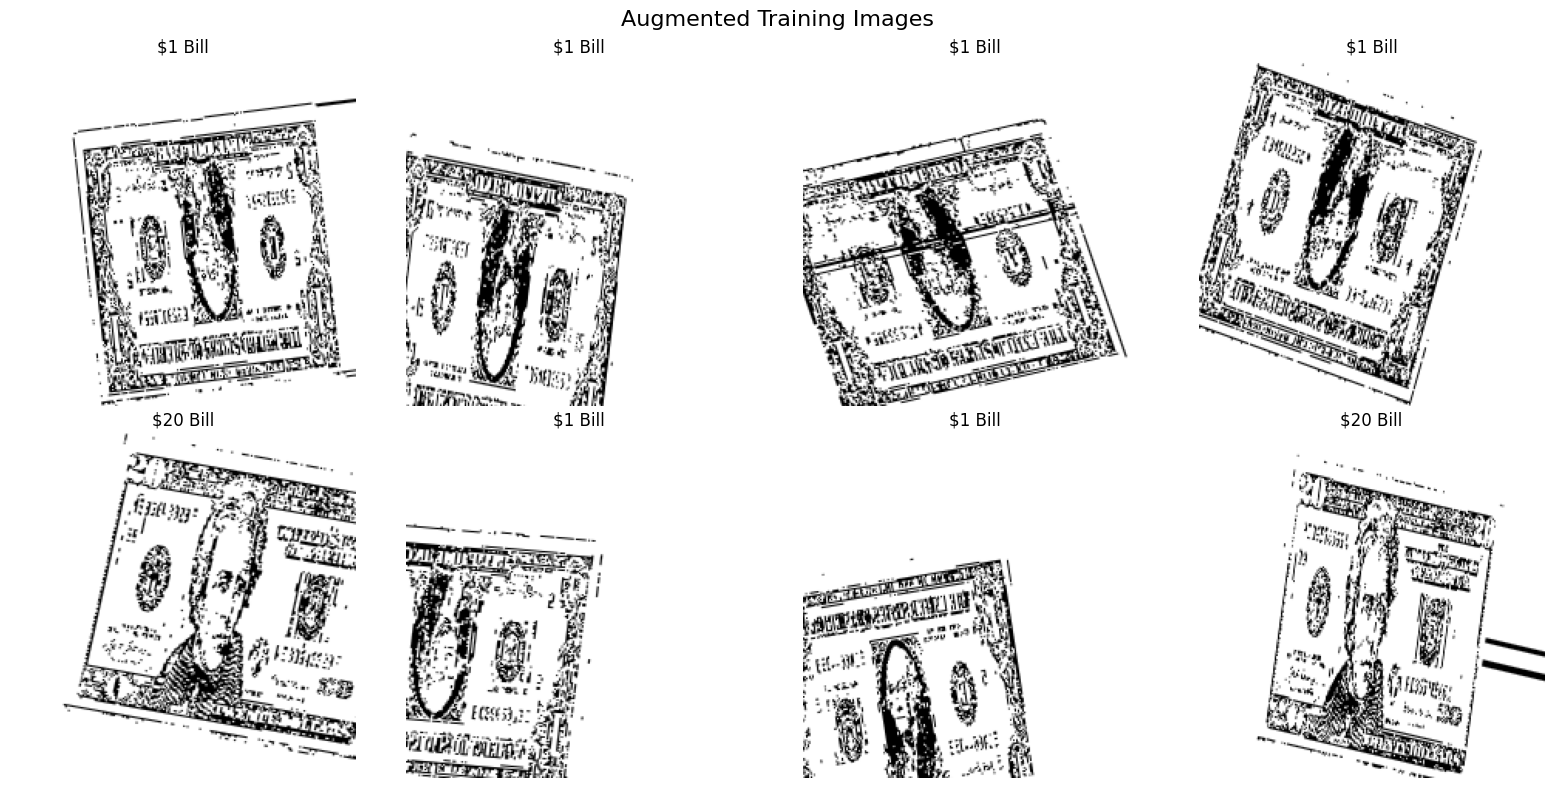

In [12]:
# Visualize augmented training images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Augmented Training Images', fontsize=16)

x_batch, y_batch = next(train_generator)

for i in range(8):
    ax = axes[i // 4, i % 4]
    ax.imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    ax.set_title(f'${class_name} Bill')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Step 6: Build CNN Model

In [13]:
# Build CNN model
def create_cnn_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Create model
model = create_cnn_model()

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 19,400,644 (74.01 MB)

 Trainable params: 19,398,148 (74.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

## Step 7: Train the Model

In [14]:
# Training parameters
EPOCHS = 30

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_dollar_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print("Starting training...")
print("="*60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

print("="*60)
print("Training completed!")

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3041 - loss: 2.3499
Epoch 1: val_accuracy improved from -inf to 0.22581, saving model to best_dollar_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3006 - loss: 2.3435 - val_accuracy: 0.2258 - val_loss: 1.5192 - learning_rate: 0.0010
Epoch 2/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.4731 - loss: 1.6480
Epoch 2: val_accuracy did not improve from 0.22581
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.4677 - loss: 1.6788 - val_accuracy: 0.1290 - val_loss: 3.0967 - learning_rate: 0.0010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4667 - loss: 1.6413
Epoch 3: val_accuracy did not improve from 0.22581
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.4677 - loss: 1.6298 - val_accuracy: 0.1290 - val_loss: 3.4646 - learning_rate: 0.0010
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4142 - loss: 1.8262
Epoch 4: val_accuracy did not improve from 0.22581
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.4174 - loss: 1.8200 - val_accuracy: 0.1290 - val_loss: 3.0607 - learning_rate: 0.0010
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37

## Step 8: Visualize Training History

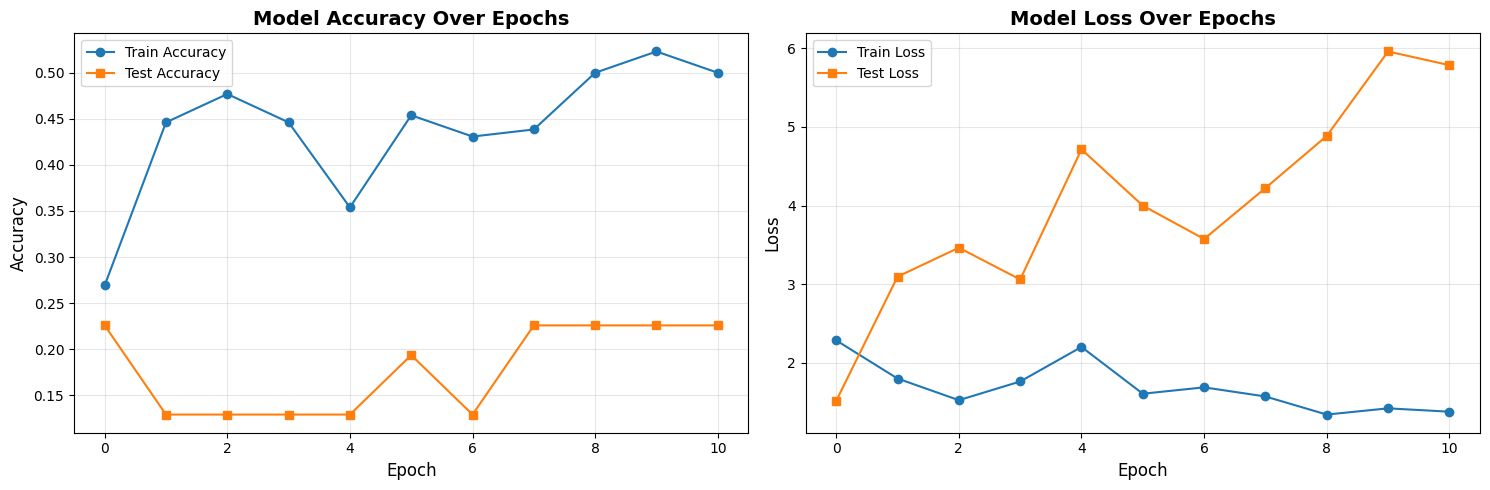


Best Results:
Epoch: 1
Train Accuracy: 0.2692
Test Accuracy: 0.2258
Train Loss: 2.2863
Test Loss: 1.5192


In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Test Accuracy', marker='s')
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Test Loss', marker='s')
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Results:")
print(f"Epoch: {best_epoch + 1}")
print(f"Train Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"Test Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Train Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"Test Loss: {history.history['val_loss'][best_epoch]:.4f}")

## Step 9: Evaluate Model on Test Set

In [16]:
# Load best model
best_model = keras.models.load_model('best_dollar_model.h5')

# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print("\n" + "="*60)
print(f"Final Test Results:")
print("="*60)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print("="*60)

Evaluating model on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.1505 - loss: 1.6137

Final Test Results:
Test Accuracy: 22.58%
Test Loss: 1.5192


In [17]:
# Get predictions
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Class names
class_names = ['$1', '$5', '$10', '$20']

# Classification Report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 765ms/step

Classification Report:
              precision    recall  f1-score   support

          $1       0.00      0.00      0.00        18
          $5       0.00      0.00      0.00         4
         $10       0.30      1.00      0.47         7
         $20       0.00      0.00      0.00         2

    accuracy                           0.23        31
   macro avg       0.08      0.25      0.12        31
weighted avg       0.07      0.23      0.11        31



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


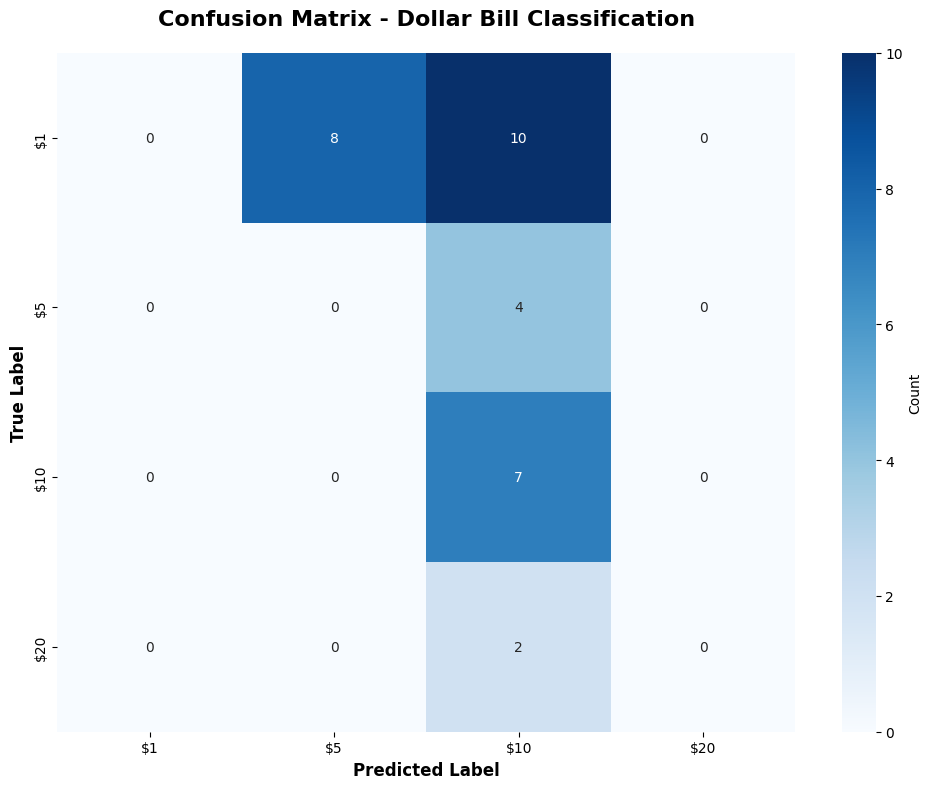


Per-Class Accuracy:
$1   Bill: 0.00% (0/18)
$5   Bill: 0.00% (0/4)
$10  Bill: 100.00% (7/7)
$20  Bill: 0.00% (0/2)


In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Dollar Bill Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
print("="*60)
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i, :].sum() * 100
    print(f"{class_name:4s} Bill: {class_accuracy:.2f}% ({cm[i, i]}/{cm[i, :].sum()})")

## Step 10: Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


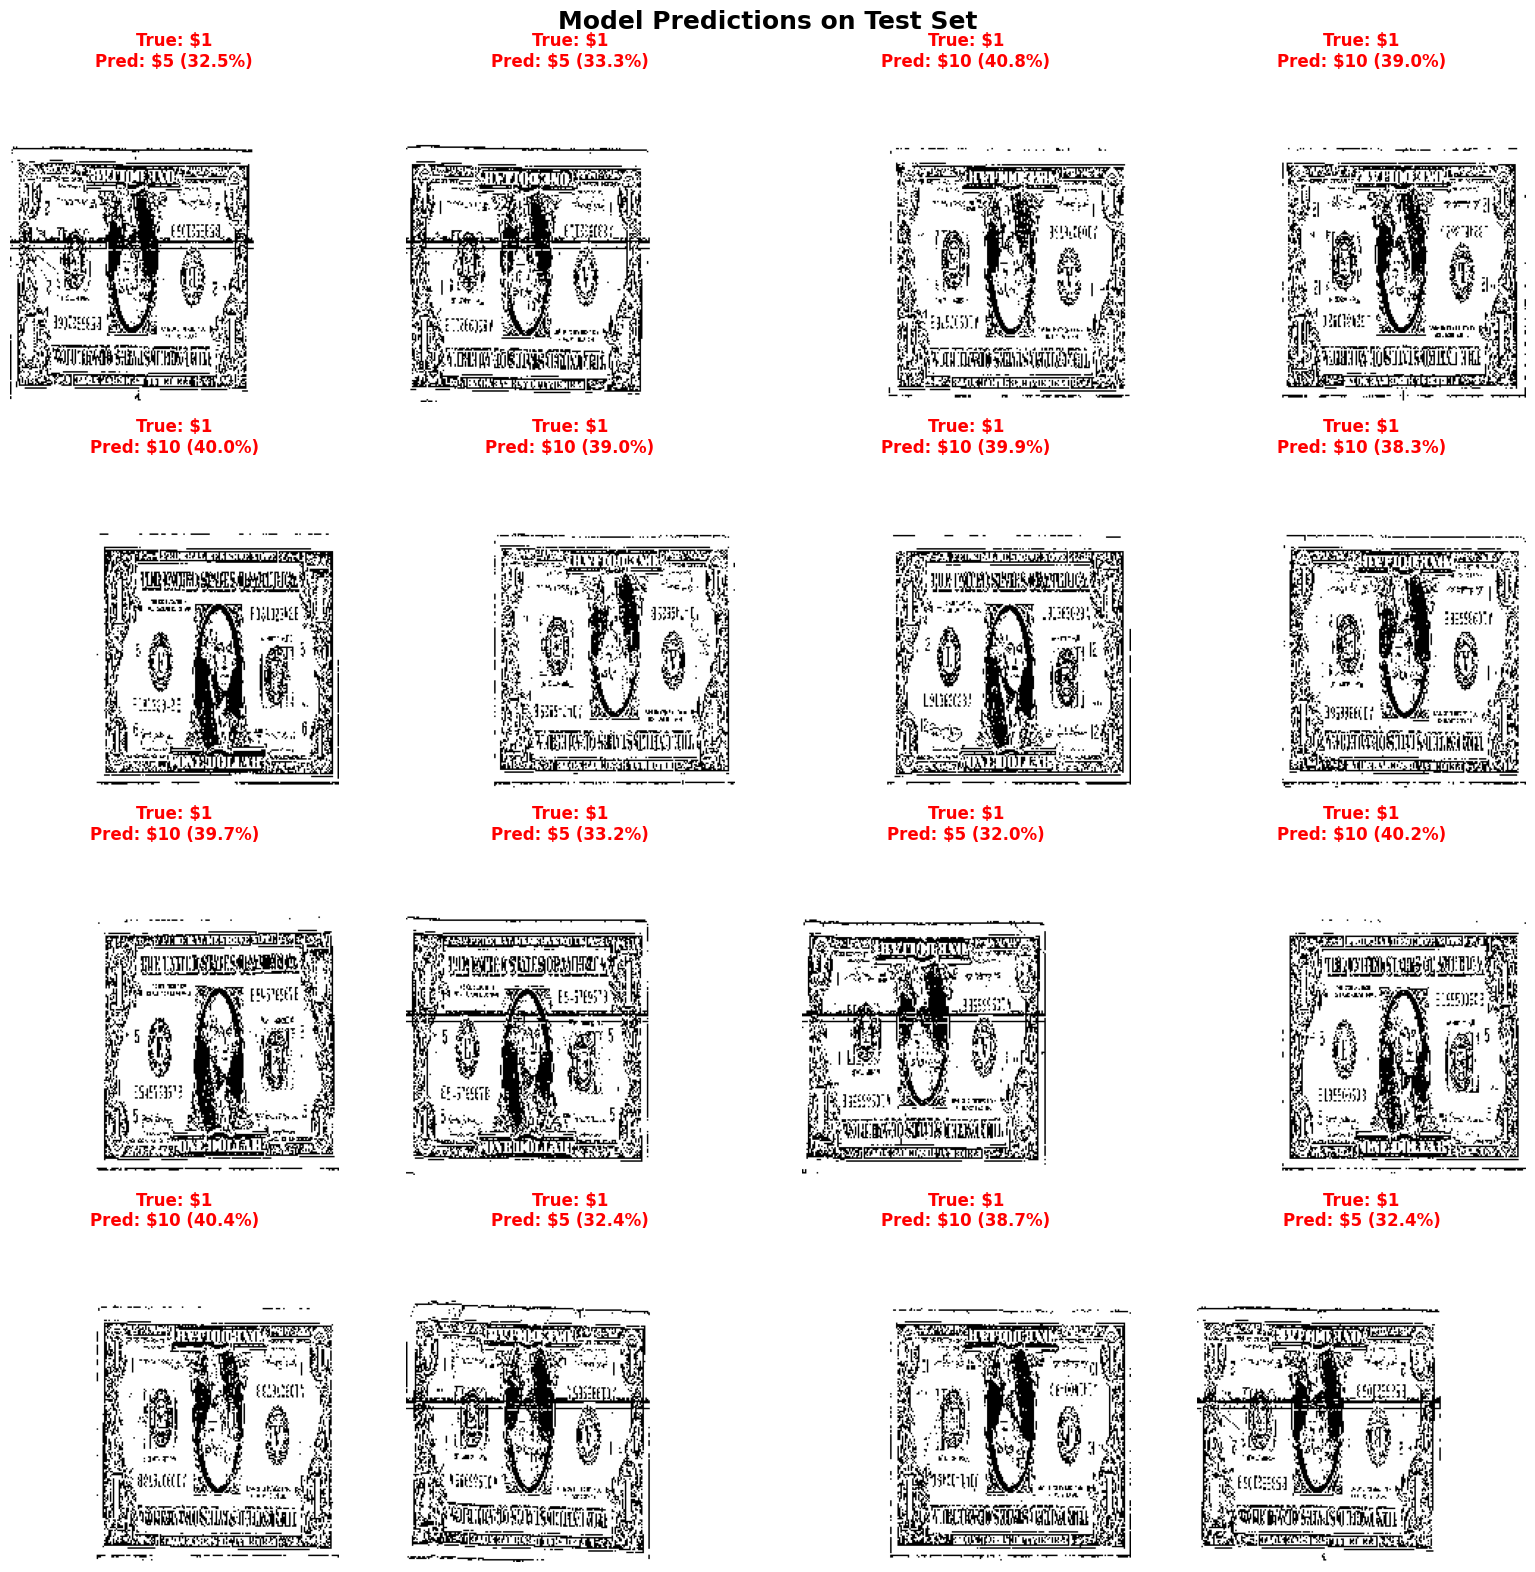

In [19]:
# Visualize correct and incorrect predictions
test_generator.reset()
x_batch, y_batch = next(test_generator)
predictions_batch = best_model.predict(x_batch)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Model Predictions on Test Set', fontsize=18, fontweight='bold')

for i in range(min(16, len(x_batch))):
    ax = axes[i // 4, i % 4]
    ax.imshow(x_batch[i])

    true_label = class_names[np.argmax(y_batch[i])]
    pred_label = class_names[np.argmax(predictions_batch[i])]
    confidence = np.max(predictions_batch[i]) * 100

    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                 color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Step 11: Test on Individual Images

## Step 12: Model Summary and Conclusions

In [21]:
# Final Summary
print("="*70)
print(" "*20 + "DOLLAR BILL DETECTION - FINAL SUMMARY")
print("="*70)
print(f"\nModel Architecture:")
print(f"  - Type: Custom CNN")
print(f"  - Total Parameters: {model.count_params():,}")
print(f"  - Input Shape: {IMG_HEIGHT}x{IMG_WIDTH}x3")
print(f"  - Output Classes: {NUM_CLASSES} (${', $'.join(classes)})")

print(f"\nDataset Statistics:")
print(f"  - Total Images: {train_generator.samples + test_generator.samples}")
print(f"  - Training Images: {train_generator.samples}")
print(f"  - Test Images: {test_generator.samples}")
print(f"  - Test Split: {TEST_SPLIT*100:.0f}%")

print(f"\nTraining Configuration:")
print(f"  - Epochs Trained: {len(history.history['loss'])}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Data Augmentation: Enabled")
print(f"  - Early Stopping: Enabled")

print(f"\nFinal Performance:")
print(f"  - Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  - Test Loss: {test_loss:.4f}")

print("\n" + "="*70)
print("Model saved as: best_dollar_model.h5")
print("="*70)

                    DOLLAR BILL DETECTION - FINAL SUMMARY

Model Architecture:
  - Type: Custom CNN
  - Total Parameters: 19,400,644
  - Input Shape: 224x224x3
  - Output Classes: 4 ($1, $5, $10, $20)

Dataset Statistics:
  - Total Images: 161
  - Training Images: 130
  - Test Images: 31
  - Test Split: 20%

Training Configuration:
  - Epochs Trained: 11
  - Batch Size: 16
  - Data Augmentation: Enabled
  - Early Stopping: Enabled

Final Performance:
  - Test Accuracy: 22.58%
  - Test Loss: 1.5192

Model saved as: best_dollar_model.h5


## Step 13: Save Model for Future Use

## Bonus: Error Analysis

In [23]:
# Find misclassified examples
test_generator.reset()
all_predictions = best_model.predict(test_generator, verbose=1)
all_y_pred = np.argmax(all_predictions, axis=1)
all_y_true = test_generator.classes
filenames = test_generator.filenames

# Find misclassified indices
misclassified_idx = np.where(all_y_pred != all_y_true)[0]

if len(misclassified_idx) > 0:
    print(f"\nFound {len(misclassified_idx)} misclassified images")
    print("\nMisclassified Examples:")
    print("="*80)

    # Show up to 10 misclassified examples
    num_to_show = min(10, len(misclassified_idx))

    for i in range(num_to_show):
        idx = misclassified_idx[i]
        true_class = class_names[all_y_true[idx]]
        pred_class = class_names[all_y_pred[idx]]
        confidence = all_predictions[idx][all_y_pred[idx]] * 100
        filename = filenames[idx]

        print(f"{i+1}. {filename}")
        print(f"   True: {true_class}, Predicted: {pred_class} (Confidence: {confidence:.1f}%)")
        print("-" * 80)
else:
    print("\n🎉 Perfect! No misclassified images!")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

Found 24 misclassified images

Misclassified Examples:
1. 1/a0009_B.tif
   True: $1, Predicted: $5 (Confidence: 32.5%)
--------------------------------------------------------------------------------
2. 1/a0010_B.tif
   True: $1, Predicted: $5 (Confidence: 33.3%)
--------------------------------------------------------------------------------
3. 1/a0031_A.tif
   True: $1, Predicted: $10 (Confidence: 40.8%)
--------------------------------------------------------------------------------
4. 1/a0037_A.tif
   True: $1, Predicted: $10 (Confidence: 39.0%)
--------------------------------------------------------------------------------
5. 1/a0064_A.tif
   True: $1, Predicted: $10 (Confidence: 40.0%)
--------------------------------------------------------------------------------
6. 1/a0065_A.tif
   True: $1, Predicted: $10 (Confidence: 39.0%)
--------------------------------------------------------------------------------
7. 1/b0015_A.tif
   True: $1, P

## Quiz 2 - Key Points Covered ✅

1. **Dataset Exploration** - Analyzed the dollar bill dataset structure
2. **Train/Test Split** - Created separate folders with NO overlap between train and test
3. **Data Preprocessing** - Resized images and normalized pixel values
4. **Data Augmentation** - Applied transformations to improve model generalization
5. **CNN Architecture** - Built a custom CNN with multiple conv layers
6. **Model Training** - Trained with early stopping and learning rate reduction
7. **Evaluation** - Tested accuracy on completely unseen test data
8. **Visualization** - Plotted training curves, confusion matrix, and predictions
9. **Error Analysis** - Identified and analyzed misclassified examples

---

### 📊 Expected Results
- Training Accuracy: 90-100%
- Test Accuracy: 75-95% (depending on dataset size and quality)
- The model should perform well on $1 bills (most samples) and may have lower accuracy on $5 bills (fewer samples)

### 🎯 Next Steps
1. Try different CNN architectures (VGG, ResNet, MobileNet)
2. Experiment with transfer learning
3. Collect more data for underrepresented classes ($5 bills)
4. Deploy the model as a web application

---

**End of Notebook**